# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Setup

In [1]:
CALIBRATION_IMAGE_FOLDER = 'camera_cal/'
TEST_IMAGE_FOLDER = 'test_images/'
TEST_IMAGE = TEST_IMAGE_FOLDER + 'test2.jpg'

THRESHOLD_RANGE = (140, 255)
DEFAULT_KERNEL_SIZE = 3

## Utilities

In [2]:
import os
import scipy.stats as stats

def get_test_image():
    return cv2.imread(TEST_IMAGE)

def get_named_test_image(name):
    return cv2.imread(TEST_IMAGE_FOLDER + name)

def get_all_test_images():
    return TEST_IMAGE_FOLDER, os.listdir(TEST_IMAGE_FOLDER)
    
def display_single_channel_image(img, title):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

"""
Used this during development to find value distribution (to find range)
"""
def draw_bell_curve(arr, min=0, max=10000):
    arr = arr.flatten()
    k = np.sort(arr)
    j = k[k>min]
    h = j[j<max]
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))
    plt.figure()
    plt.plot(h,fit,'-o')
    plt.hist(h,normed=True)
    plt.show()

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### 1.1 Computation of camera calibration matrix and distortion coefficients.

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_distortion_vars():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(CALIBRATION_IMAGE_FOLDER + 'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)

def undistort(img):
    ret, mtx, dist, rvecs, tvecs = get_distortion_vars()
    return cv2.undistort(img, mtx, dist, None, mtx)

### 1.2. Test for image distortion correction on chessboard image

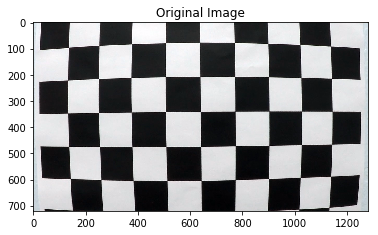

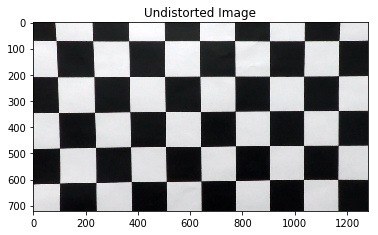

In [4]:
img = cv2.imread(CALIBRATION_IMAGE_FOLDER + 'calibration1.jpg')

plt.title('Original Image')
plt.imshow(img)

plt.figure()
plt.title('Undistorted Image')
undistorted = undistort(img)
plt.imshow(undistorted)

## 2. Apply distortion correction to raw images.

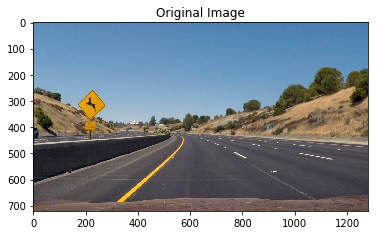

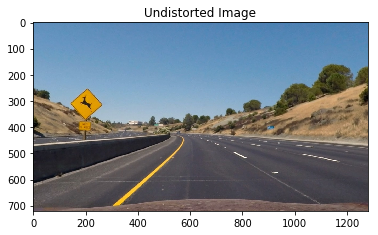

In [5]:
original = get_test_image()
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.title('Original Image')
plt.imshow(rgb)

plt.figure()
plt.title('Undistorted Image')
undistorted = undistort(rgb)
plt.imshow(undistorted)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

### 3.1 HLS and Color Thresholds

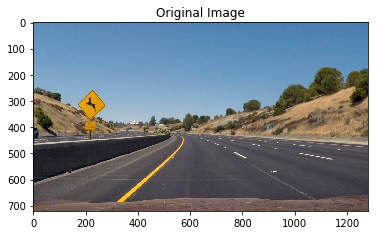

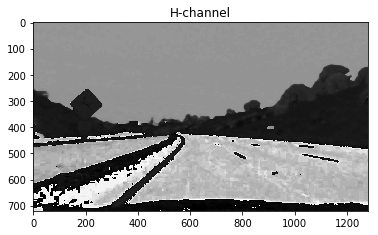

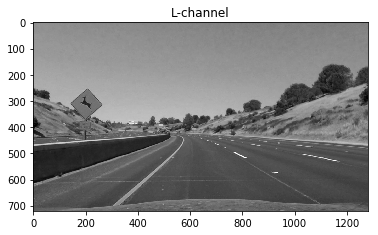

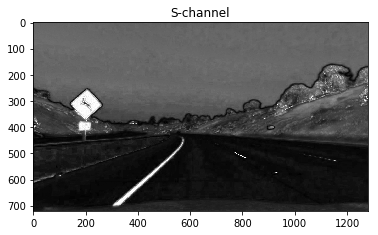

In [6]:
def display_hls_channel_images(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    plt.figure()
    rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    plt.title('Original Image')
    plt.imshow(rgb)

    display_single_channel_image(H, 'H-channel')
    display_single_channel_image(L, 'L-channel')
    display_single_channel_image(S, 'S-channel')
    
original = cv2.imread(TEST_IMAGE)
undistorted = undistort(original)
display_hls_channel_images(undistorted)

### 3.2 Threshold codes taken from Course resources

In [55]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=DEFAULT_KERNEL_SIZE, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=DEFAULT_KERNEL_SIZE, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

# Threshold derived from S channel of the image converted to HLS
def s_channel_threshold(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def get_thresholds(image):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=DEFAULT_KERNEL_SIZE, mag_thresh=(10, 100))
    dir_binary = dir_threshold(image, sobel_kernel=DEFAULT_KERNEL_SIZE, thresh=(0.7, 1.3))
    s_channel_binary = s_channel_threshold(image, THRESHOLD_RANGE)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_channel_binary == 1)] = 1
    
    return gradx, grady, mag_binary, dir_binary, s_channel_binary, combined

### 3.3 Example of thresholded image

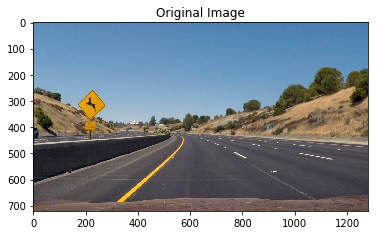

In [56]:
original = get_test_image()
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
plt.title('Original Image')
plt.imshow(rgb)

undistorted = undistort(original)
threshold = get_thresholds(undistorted)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

### 4.1 Finding street endpoints from a straight road for perspective transform

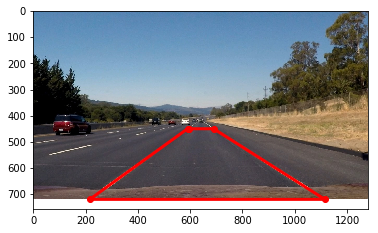

In [66]:
img = get_named_test_image('straight_lines2.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(rgb)
X = [595, 690, 1115, 216, 590]
Y = [450, 450, 720, 720, 450]
plt.plot(X, Y, 'ro-', linewidth=3)

#### We'll go ahead and use the four points - (595, 450), (690, 450), (1115, 720) and (216, 720) from the straight road for perspective transform.

### 4.2 Using the four coordinates from above to perform perspective image on other road image.

In [67]:
def endpoints_for_perspective_transform():
    return np.array([[[595, 450], [690, 450], [1115, 720], [216, 720]]], dtype=np.int32)

def road_mask(img):
    pts = endpoints_for_perspective_transform()
    mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv2.fillPoly(mask, pts, color=(0, 80, 0))
    return mask

def warp(img, pts, marginx=200, marginy=0):
    warped = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    height, width = img.shape[0], img.shape[1]
    src = pts[0].astype('float32')
    
    new_window = np.int32([
        [0, 0],
        [width-1, 0],
        [width-1, height-1],
        [0, height]]).astype('float32')
    offset = np.int32([
        [marginx, marginy],
        [-marginx, marginy],
        [-marginx, -marginy],
        [marginx, -marginy]]).astype('float32')
    dst = new_window + offset
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return warped, M

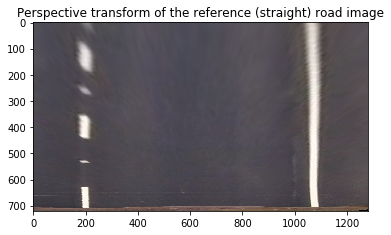

In [68]:
img = get_named_test_image('straight_lines2.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pts = endpoints_for_perspective_transform()
warped, M = warp(rgb, pts)
plt.figure()
plt.title('Perspective transform of the reference (straight) road image')
plt.imshow(warped)

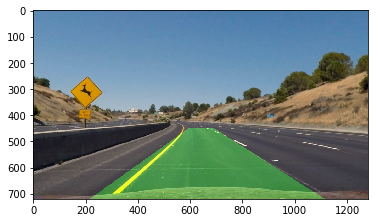

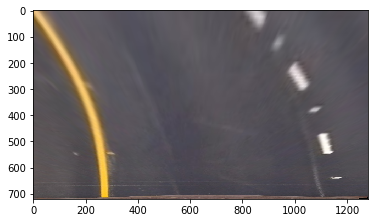

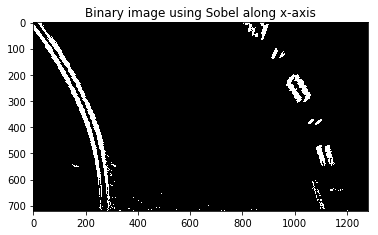

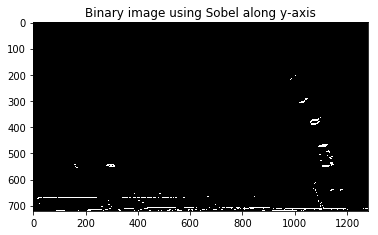

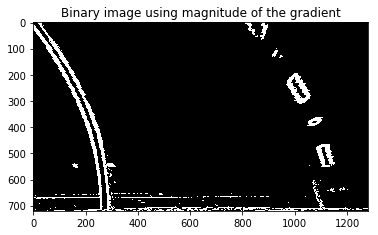

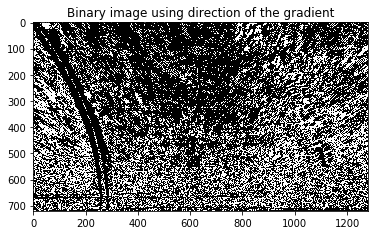

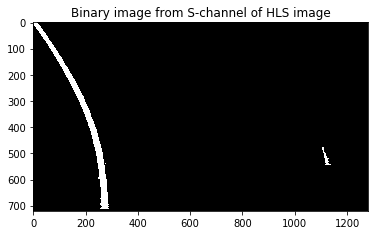

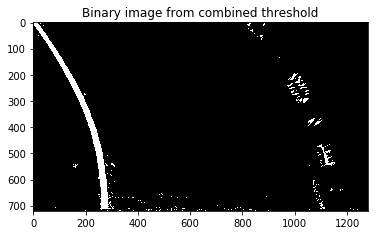

In [70]:
img = get_test_image()
undistorted = undistort(img)
rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

mask = road_mask(rgb)
overlay = weighted_img(mask, rgb, 0.95, 1., 0)
plt.figure()
plt.imshow(overlay)

pts = endpoints_for_perspective_transform()
warped, M = warp(rgb, pts)
plt.figure()
plt.imshow(warped)

gradx, grady, mag_binary, dir_binary, s_channel_binary, combined = get_thresholds(warped)

display_single_channel_image(gradx, 'Binary image using Sobel along x-axis')
display_single_channel_image(grady, 'Binary image using Sobel along y-axis')
display_single_channel_image(mag_binary, 'Binary image using magnitude of the gradient')
display_single_channel_image(dir_binary, 'Binary image using direction of the gradient')
display_single_channel_image(s_channel_binary, 'Binary image from S-channel of HLS image')
display_single_channel_image(combined, 'Binary image from combined threshold')

## 5. Detect lane pixels and fit to find the lane boundary.